# Use fastai to train on the nottingham dataset using Google colaboratory

## Setup: install packages and unzip data

In [0]:
%%capture
!pip install torch torchvision
!pip install fastai
!pip install music21 matplotlib scipy numpy pyknon

In [0]:
%%capture
!unzip processed_data_merged.zip

## Imports

In [0]:
from fastai.text import *
import argparse
import random
import os
import numpy as np
from math import floor
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note
import music21
from pathlib import Path
from fastai.text.transform import *
import torch
from google.colab import files

## Functions to decode generated output to music21 stream that can be saved as MIDI file

In [0]:
def decode_chordwise_string(string):
  
  sample_freqs=[4,12]
  note_ranges=[38,62]
  note_offsets={}
  note_offsets[38]=45
  note_offsets[62]=33

  sample_freq = sample_freqs[0] # 4
  note_range = note_ranges[0]   # 38
  note_offset = note_offsets[note_range]
  chamber = False
  
  score = string.split(" ")
  speed = 1. / sample_freq
  piano_notes = []
  violin_notes = []
  time_offset = 0
  for i in range(len(score)):
      current_chord = score[i]
      if len(current_chord) == 0:
          print("chord len is 0, no note played, continue")
          continue
      for j in range(1, len(current_chord)):
          if current_chord[j] == "1":
              duration = 2  # why 2 ???
              new_note = music21.note.Note(j + note_offset)    
              new_note.duration = music21.duration.Duration(duration * speed)
              new_note.offset = (i + time_offset) * speed
              if current_chord[0] == 'p':
                  piano_notes.append(new_note)
              elif current_chord[0] == 'v':
                  violin_notes.append(new_note)
  violin = music21.instrument.fromString("Violin")
  piano = music21.instrument.fromString("Piano")
  violin_notes.insert(0, violin)
  piano_notes.insert(0, piano)
  violin_stream = music21.stream.Stream(violin_notes)
  piano_stream = music21.stream.Stream(piano_notes)
  main_stream = music21.stream.Stream([violin_stream, piano_stream])
  return main_stream

In [0]:
def decode_notewise_string(string):
    
    score = string.split(" ")
    
    sample_freqs=[4,12]
    note_ranges=[38,62]
    note_offsets={}
    note_offsets[38]=45
    note_offsets[62]=33

    sample_freq = sample_freqs[0] # 4
    note_range = note_ranges[0]   # 38
    note_offset = note_offsets[note_range]
    chamber = False
    
    speed = 1./sample_freq
    piano_notes = []
    violin_notes = []
    time_offset = 0
    i = 0
    while i < len(score):
        if score[i][:9] == "p_octave_":
            add_wait = ""
            if score[i][-3:] == "eoc":
                add_wait = "eoc"
                score[i] = score[i][:-3]
            this_note = score[i][9:]
            score[i] = "p" + this_note
            score.insert(i + 1, "p" + str(int(this_note) + 12) + add_wait)
            i += 1
        i += 1
    for i in range(len(score)):
        if score[i] in ["", " ", "<eos>", "<unk>"]:
            continue
        elif score[i][:3] == "end":
            if score[i][-3:] == "eoc":
                time_offset += 1
            continue
        elif score[i][:4] == "wait":
            time_offset += int(score[i][4:])
            continue
        else:
            duration = 1
            has_end = False
            note_string_len = len(score[i])
            for j in range(1,200):
                if i + j == len(score):
                    break
                if score[i + j][:4] ==" wait":
                    duration += int(score[i + j][4:])
                if score[i + j][:3 + note_string_len] == "end" + score[i] or score[i + j][:note_string_len] == score[i]:
                    has_end = True
                    break
                if score[i + j][-3:] == "eoc":
                    duration += 1
            if not has_end:
                duration = 12
            add_wait = 0
            if score[i][-3:] == "eoc":
                score[i] = score[i][:-3]
                add_wait = 1
            try: 
                new_note = music21.note.Note(int(score[i][1:]) + note_offset)    
                new_note.duration = music21.duration.Duration(duration * speed)
                new_note.offset = time_offset * speed
                if score[i][0] == "v":
                    violin_notes.append(new_note)
                else:
                    piano_notes.append(new_note)
            except:
                print("Unknown note: " + score[i])           
            time_offset += add_wait
    violin = music21.instrument.fromString("Violin")
    piano = music21.instrument.fromString("Piano")
    violin_notes.insert(0, violin)
    piano_notes.insert(0, piano)
    violin_stream = music21.stream.Stream(violin_notes)
    piano_stream = music21.stream.Stream(piano_notes)
    main_stream = music21.stream.Stream([violin_stream, piano_stream])
    return main_stream

## Helper methods

In [0]:
# remove all rules from tokenizer so that
# the only thing it does is split by spaces
# for tokenizer behavior see https://docs.fast.ai/text.transform.html#Tokenizer
tok = Tokenizer(pre_rules=[], post_rules=[], special_cases=[])

In [0]:
# create databunch
# min_frwq = 1 because we don't want any word dropped, our
## vocab is not that big
# include_bos is unnessesary, since we will only ever generate on
## sequence (song) at a time
def create_default_databunch(data_path):
    return TextLMDataBunch.from_folder(
        path=data_path, 
        train="train", 
        valid="valid",
        test="test", 
        min_freq=1,
#         bptt=70,
        tokenizer=tok, 
        include_bos=False
    )

## Train a chordwise language model

In [0]:
data_path_chordwise = "processed_data/chordwise"

In [0]:
config = awd_lstm_lm_config.copy()
config

In [0]:
chordwise_databunch = create_default_databunch(data_path=data_path_chordwise)
# save databunch to avoid having to do it again
## (time intense for large datasets)
chordwise_databunch.save("/content/chordwise_databunch_export.pkl")

In [0]:
chordwise_databunch = TextLMDataBunch.load("/content/chordwise_databunch_export.pkl")

In [88]:
chordwise_databunch.show_batch()

idx,text
0,p00000000000010001000010000001000010000 pnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn pnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii p00000000000001000000000000000000000000 piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii p00000000000000000000000000000001000000 piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii p00000000000000100000000000100100000000 pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk pffffffffffffffffffffffffffffffffffffff p00000000000000000000000000000100000000 pgggggggggggggggggggggggggggggggggggggg pgggggggggggggggggggggggggggggggggggggg pffffffffffffffffffffffffffffffffffffff p00001000010000000001010000000000000000 piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii pffffffffffffffffffffffffffffffffffffff p00000000000000000000000001000000000000 pgggggggggggggggggggggggggggggggggggggg pgggggggggggggggggggggggggggggggggggggg pffffffffffffffffffffffffffffffffffffff p00000100010000000100010000000000000000 pjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj p00000000000000000000000000100000000000 pgggggggggggggggggggggggggggggggggggggg p00000000000000000100000100100000000100 pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk p00000000000000000000000000000000010000 pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk p00001000000100001000000100100000010000 pqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq pqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq pmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm p00000000000000000000000000000000100000 pmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm pmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii p00000000000000100000000000000000000000 p00000000000000000000000000001000000000 p00000000000000000000000000000010000000 peeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee p00000000000000001000100100000000100000 p00000000000000000000000000000000010000 p00000000000000000000000000000000000100 pjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj p00000000000010000000000000000000000000 pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk pjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj p00000000000000001000010010000000000000 pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk pgggggggggggggggggggggggggggggggggggggg p00000000000100000000000000000000000000 p00000000000000000000000000001000000000 p00000000000000000000000000000010000000 pgggggggggggggggggggggggggggggggggggggg p00000000000000001000100000100000100000 p00000000000000000000000000000000010000 p00000000000000000000000000000000000100 pjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj p00000000010000000000000000000000000000 pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk pjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj p00000000000000001001000001000000000000 pkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
1,pgggggggggggggggggggggggggggggggggggggg pgggggggggggggggggggggggggggggggggggggg pcccccccccccccccccccccccccccccccccccccc p00000001001000100000001000000000000000 pgggggggggggggggggggggggggggggggggggggg pgggggggggggggggggggggggggggggggggggggg pffffffffffffffffffffffffffffffffffffff p00000000000000000000001000000000000000 pgggggggggggggggggggggggggggggggggggggg p00000000000000000000000010000000000000 pgggggggggggggggggggggggggggggggggggggg p00000000000000000000001000000000000000 phhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh p00000000000000000000010000000000000000 peeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee p00000000000010001001001000000000000000 piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii piiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii phhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh phhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh pgggggggggggggggggggggggggggggggggggggg pgggggggggggggggggggggggggggggggggggggg pffffffffffffffffffffffffffffffffffffff p00000000000000000000000000000100000000 pffffffffffffffffffffffffffffffffffffff pffffffffffffffffffffffffffffffffffffff pbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb p00000100010010000000000010000000000000 pffffffffffffffffffffffffffffffffffffff pffffffffffffffffffffffffff

In [0]:
learner_chordwise = None
learner_chordwise = language_model_learner(chordwise_databunch, arch=AWD_LSTM , config=config)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


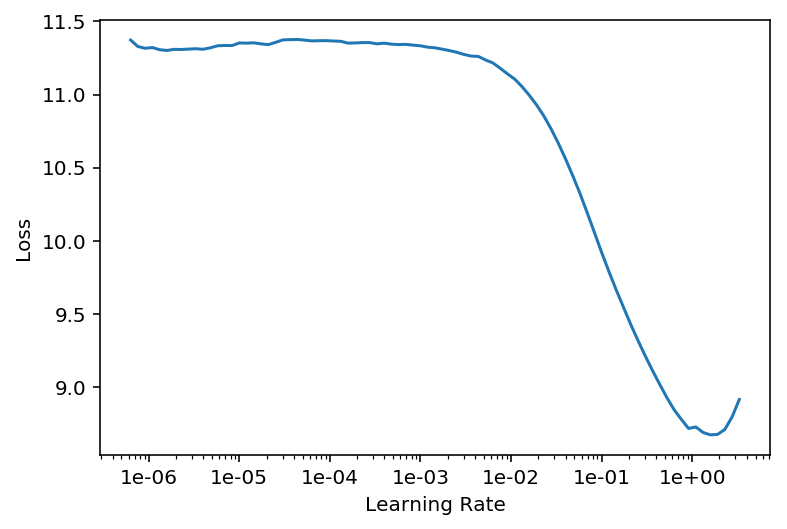

In [0]:
# find best lr and show plot
learner_chordwise.lr_find()
learner_chordwise.recorder.plot()

In [0]:
# run training
# See https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?
# https://forums.fast.ai/t/why-do-we-need-to-unfreeze-the-learner-everytime-before-retarining-even-if-learn-fit-one-cycle-works-fine-without-learn-unfreeze/41614/5
learner_chordwise.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,3.230626,2.570084,0.430032,15:23


In [0]:
learner_chordwise.unfreeze()
learner_chordwise.fit_one_cycle(1, 1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,2.090430,1.598667,0.647082,18:10


In [0]:
learner_chordwise.unfreeze()
learner_chordwise.fit_one_cycle(1, 1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,1.782288,1.487033,0.673698,18:09


In [0]:
learner_chordwise.freeze()
learner_chordwise.fit_one_cycle(1, 1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,1.879439,1.481238,0.675347,15:39


In [0]:
learner_chordwise.unfreeze()
learner_chordwise.fit_one_cycle(1, 1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,1.710099,1.429308,0.687846,18:12


In [0]:
learner_chordwise.unfreeze()
learner_chordwise.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.869147,1.485611,0.679809,18:10


In [0]:
learner_chordwise = learner_chordwise.load("/content/chordwise_model_v4")

In [0]:
learner_chordwise.freeze()
learner_chordwise.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,1.695012,1.428145,0.689880,15:38


In [0]:
learner_chordwise.freeze()
learner_chordwise.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,1.890985,1.460214,0.686545,15:37


Stopped training at this point.

In [0]:
learner_chordwise = learner_chordwise.load("/content/chordwise_model_v5")

In [0]:
learner_chordwise.unfreeze()
learner_chordwise.fit_one_cycle(1, 1e-04)

epoch,train_loss,valid_loss,accuracy,time
0,1.577501,1.409741,0.693528,18:11


In [0]:
fname = "chordwise_model_v5"

In [0]:
# generate a sequence
gen = learner_chordwise.predict(text="p00000000000000000000100000000000000000 p00000000000000000000010000000000000000", n_words=200, temperature=0.95)
stream = decode_chordwise_string(gen)
decoded_notes_file = stream.write('midi', f'{fname}_3.mid')

In [0]:
pred1 = learner_chordwise.predict("p00000000000000000000000000100000000000", 400)
pred2 = learner_chordwise.predict("", 400)

In [0]:
pred1

In [0]:
# # save learned model
desc = f"chordwise, merged datasets, 6 epochs, 0.689880 acc, n_hid=1152(default), 3 layers (default), pretrained weights: True (default), dropout_mult=1.0(default)"
desc += f"\nepoch     lr         acc         weights"
desc += f"\n1         1e-01      0.430032    frozen"
desc += f"\n2         1e-03      0.647082    unfrozen"
desc += f"\n3         1e-03      0.673698    unfrozen"
desc += f"\n4         1e-03      0.675347    frozen"
desc += f"\n5         1e-02      0.687846    unfrozen"
desc += f"\n6         1e-02      0.689880    frozen"
# desc += f"\n7         1e-03      0.746206    unfrozen"
# desc += f"\n8         1e-03      0.747563    unfrozen"
# desc += f"\n9         1e-03      0.748488    frozen"

learner_chordwise.save(f"/content/{fname}")

with open(f"{fname}.txt", "w") as f:
    f.write(desc)
    
# from google.colab import files
files.download(f"/content/{fname}.txt")
files.download(f"/content/{fname}.pth")

## Train a notewise language model

In [0]:
data_path_notewise = "processed_data/notewise"

In [84]:
config = awd_lstm_lm_config.copy()
config

{'bidir': False,
 'emb_sz': 400,
 'embed_p': 0.02,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'n_hid': 1152,
 'n_layers': 3,
 'out_bias': True,
 'output_p': 0.1,
 'pad_token': 1,
 'qrnn': False,
 'tie_weights': True,
 'weight_p': 0.2}

In [0]:
notewise_databunch = create_default_databunch(data_path=data_path_notewise)
# save databunch to avoid having to do it again
## (time intense for large datasets)
notewise_databunch.save("/content/notewise_databunch_export.pkl")

In [0]:
notewise_databunch = TextLMDataBunch.load("/content/notewise_databunch_export.pkl")

In [86]:
notewise_databunch.show_batch()

idx,text
0,p15 p18 wait6 p37 endp37 wait1 endp11 endp15 endp18 wait1 p16 p20 p23 wait4 p37 wait1 endp37 wait1 p35 wait1 endp16 endp20 endp23 endp35 wait1 p18 p22 p25 p28 p34 wait1 endp34 wait1 p35 wait1 endp35 wait1 p37 wait1 endp37 wait2 endp22 endp25 endp28 wait1 p11 p15 p18 p35 wait4 p35 wait1 endp35 wait1 p30 wait1 endp30 wait1 p11 p15 p18 wait6 p37 endp37 wait1 endp11 endp15 endp18 wait1 p16
1,p12 p24 wait3 endp24 wait1 p29 wait4 p29 wait3 endp29 wait1 p31 wait1 endp31 wait1 p33 wait1 endp33 wait1 p5 p9 p12 p34 wait1 endp34 wait1 p33 wait1 endp33 wait1 p31 wait1 endp31 wait1 p29 wait1 endp29 wait1 p33 wait7 endp5 endp9 endp12 endp33 wait1 p7 p10 p14 p34 wait3 endp34 wait1 p26 wait3 endp26 wait1 p28 wait1 endp28 wait1 p29 wait1 endp29 wait1 p31 wait1 endp31 wait1 p28 wait1
2,wait3 endp36 wait1 p35 wait1 endp16 endp19 endp35 wait1 p5 p9 p12 p33 wait3 endp33 wait1 p29 wait1 endp29 wait1 p26 wait3 endp26 wait1 p36 wait1 endp5 endp9 endp12 endp36 wait1 p7 p11 p14 p17 p35 wait1 endp35 wait1 p33 wait1 endp33 wait1 p31 wait1 endp31 wait1 p29 wait1 endp29 wait1 p28 wait1 endp28 wait1 p26 wait1 endp7 endp11 endp14 endp17 endp26 wait1 p12 p16 p19 p24 wait6 p24 wait3
3,p22 p34 wait1 endp15 endp19 endp22 wait2 endp34 wait1 p10 p29 wait1 endp10 wait3 p10 p14 p17 p20 wait1 endp10 endp14 endp17 endp20 endp29 wait1 p31 wait1 endp31 wait1 p10 p29 wait1 endp10 wait2 endp29 wait1 p10 p14 p17 p20 p31 wait1 endp10 endp14 endp17 endp20 endp31 wait1 p32 wait1 endp32 wait1 p15 p34 wait1 endp15 wait2 endp34 wait1 p15 p19 p22 p31 wait1 endp15 endp19 endp22 endp31 wait1 p32
4,p22 p25 p34 wait2 p14 endp14 wait1 endp22 endp25 endp34 wait1 p9 endp9 p18 endp18 p21 endp21 p24 endp24 p33 endp33 wait2 p14 endp14 wait2 p9 endp9 p14 endp14 p18 endp18 p24 endp24 p26 endp26 wait2 p14 endp14 wait2 p9 endp9 p18 endp18 p24 endp24 p26 endp26 p33 endp33 wait2 p14 endp14 wait2 p9 endp9 p14 endp14 p18 endp18 p24 endp24 p26 endp26 wait2 p14 endp14 wait2 p9 endp9 p18


In [0]:
learner_notewise = language_model_learner(notewise_databunch, arch=AWD_LSTM , config=config)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


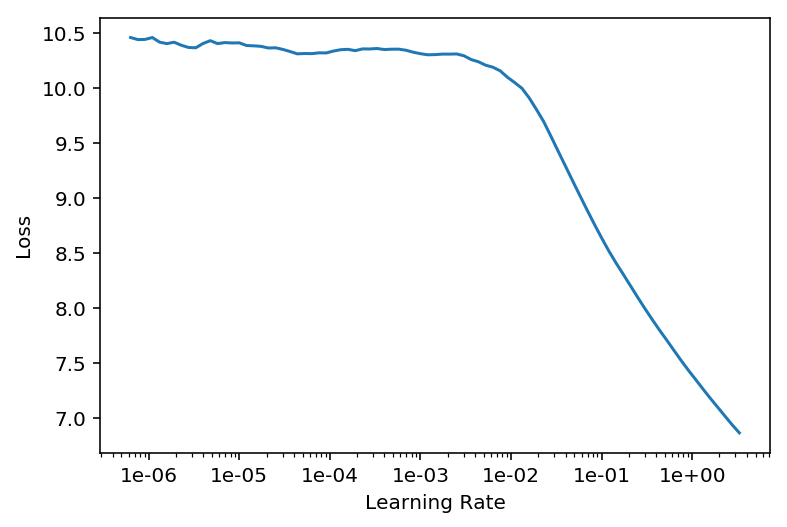

In [89]:
# find best lr and show plot
learner_notewise.lr_find()
learner_notewise.recorder.plot()

In [91]:
# run training
# See https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?
# https://forums.fast.ai/t/why-do-we-need-to-unfreeze-the-learner-everytime-before-retarining-even-if-learn-fit-one-cycle-works-fine-without-learn-unfreeze/41614/5
learner_notewise.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,2.045557,1.684096,0.546817,15:14


In [92]:
learner_notewise.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,2.078626,1.676736,0.548770,15:15


In [0]:
learner_notewise.unfreeze()
learner_notewise.fit_one_cycle(1, 1e-01)

epoch,train_loss,valid_loss,accuracy,time


In [0]:
fname = "notewise_model_v1"

In [0]:
# generate a sequence
gen = learner_notewise.predict(text="wait1", n_words=800, temperature=0.8)
stream = decode_notewise_string(gen)
decoded_notes_file = stream.write('midi', f'{fname}_3.mid')

In [97]:
gen

'wait1 p21 endp21 p23 endp23 wait1 p21 p24 p26 wait1 endp24 wait1 p9 p12 p16 p19 p28 wait2 p28 endp28 wait1 p31 wait1 endp31 wait1 p31 wait1 endp31 wait1 p28 wait1 endp28 wait1 p28 wait1 endp28 wait1 p30 wait1 endp30 wait1 p33 wait1 endp33 wait1 p33 endp33 wait1 p28 wait1 endp28 wait1 p26 p30 wait1 endp26 wait1 p28 wait2 p28 wait1 endp28 wait1 p26 wait5 endp26 wait1 p28 wait1 endp28 wait1 p25 p33 wait3 endp5 endp9 endp12 endp16 endp25 endp28 wait1 p14 p26 wait1 endp26 wait1 p23 wait1 endp23 wait1 p26 wait1 endp26 wait1 p7 p11 p14 p23 p23 endp23 wait1 p29 wait1 endp29 wait1 p14 endp14 wait1 p28 p31 endp31 wait1 p9 p13 p16 p20 p33 wait1 endp9 endp13 endp16 endp20 wait1 p28 endp28 wait1 p15 endp15 wait1 p7 p10 p14 p19 p22 wait1 endp22 wait1 p14 p20 wait1 endp12 endp15 wait1 p9 p12 p15 p18 p29 wait5 endp29 wait1 p26 wait1 endp26 wait1 p26 wait1 endp26 wait1 p24 wait1 endp24 wait1 p26 wait1 endp26 wait1 p28 wait1 endp28 wait1 p12 p15 p19 p22 wait1 p31 wait1 endp19 endp31 wait1 p14 wait1 p19

In [0]:
learner_notewise = LanguageLearner.load(f"/content/{fname}")

In [0]:
# # save learned model
desc = f"notewise, merged datasets, 2 epochs, 0.689880 acc, n_hid=1152(default), 3 layers (default), pretrained weights: True (default), dropout_mult=1.0(default)"
desc += f"\nepoch     lr         acc         weights"
desc += f"\n1         1e-01      0.430032    frozen"
desc += f"\n2         1e-03      0.647082    unfrozen"
# desc += f"\n3         1e-03      0.673698    unfrozen"
# desc += f"\n4         1e-03      0.675347    frozen"
# desc += f"\n5         1e-02      0.687846    unfrozen"
# desc += f"\n6         1e-02      0.689880    frozen"
# # desc += f"\n7         1e-03      0.746206    unfrozen"
# # desc += f"\n8         1e-03      0.747563    unfrozen"
# # desc += f"\n9         1e-03      0.748488    frozen"

learner_chordwise.save(f"/content/{fname}")

with open(f"{fname}.txt", "w") as f:
    f.write(desc)
    
# from google.colab import files
# files.download(f"/content/{fname}.txt")
# files.download(f"/content/{fname}.pth")